In [2]:
# # GOOGLE COLAB
import os
from google.colab import drive
drive.mount('/content/drive')
# change working directory if not done already
if os.getcwd().split('/')[-2] != 'My Drive':
   os.chdir('drive/MyDrive/laba')

Mounted at /content/drive


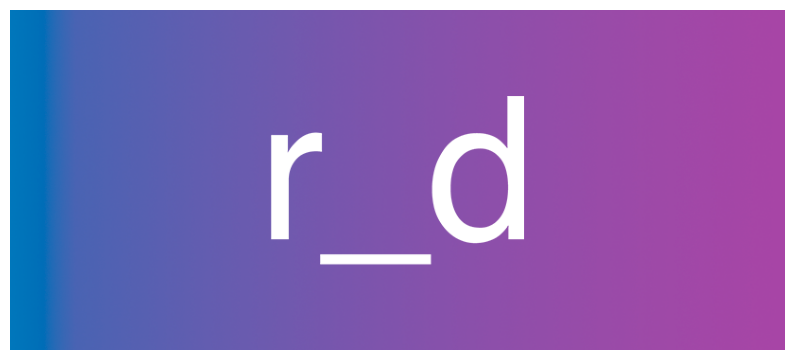

In [3]:
import rd_utils as rdu
rdu.show_logo()

<font size="10">Lekce 4 - domácí úloha</font>

- V této domácí úloze si procvičíte klasifikační úlohu s využitím logistické regrese i rozhodovacích stromů.
- Budete pracovat se stejným datasetem, jako v první úloze.
- Tentokrát však úlohu "obrátíme" - zatímco předtím byla naší cílovou (vysvětlovanou) proměnnou `charges`, nyní to bude kategorická proměnná `is_smoker`.

**Instrukce:**

 - vyplň všechna místa v kódu, kde je uvedeno "STUDENT"
 - nemaž předvyplněný kód v buňkách (např. `y_clf.head()` nebo  `y_pred[:5]`), aby bylo možné zkontrolovat Tvůj výsledek

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Načtení dat

In [6]:
df_raw = pd.read_csv('datasets/medical_cost_personal/insurance.csv')

**Dataset Medical cost personal**

*zdroj: https://www.kaggle.com/datasets/mirichoi0218/insurance*

Dataset "Medical Cost Personal" na Kaggle obsahuje informace o nákladech na zdravotní péči. Tento dataset obsahuje údaje o pacientech, jako jsou věk, pohlaví, kuřáctví, region, počet dětí a další. Hlavním cílem je analyzovat náklady na zdravotní péči v závislosti na těchto faktorech. Tento dataset lze využít k provádění analýz a predikcí v oblasti nákladů na zdravotní péči a může být užitečný pro zdravotní pojišťovny, lékaře a výzkumníky v oblasti zdravotní ekonomiky.

- age: Věk hlavního pojištěnce
- sex: Pohlaví pojišťovatele, žena, muž
- bmi: Index tělesné hmotnosti poskytující pochopení tělesné stavby, hmotnosti, která je relativně vysoká nebo nízká ve vztahu k výšce, objektivní ukazatel tělesné hmotnosti (kg/m^2) pomocí poměru výšky k hmotnosti, ideálně 18,5 až 24,9
- children: Počet dětí pokrytých zdravotním pojištěním / Počet závislých osob
- smoker: Kuřáctví
- region: Místo bydliště příjemce v USA, severovýchod, jihovýchod, jihozápad, severozápad.
- charges: Individuální lékařské náklady fakturované zdravotním pojištěním

In [7]:
df_raw.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Preprocessing dat

- Soupec pro pohlaví (`sex`) je nahrazen 0/1 proměnnou `is_male` (je muž).
- Soupec `smoker` je nahrazen 0/1 proměnnou `is_smoker` (je kuřák).

In [8]:
df = df_raw.copy()
df['is_male'] =  df['sex'].replace({'female': '0', 'male': '1'}).astype(np.int8)
df['is_smoker'] =  df['smoker'].replace({'no': '0', 'yes': '1'}).astype(np.int8)
df.drop(columns=['sex', 'smoker', 'region'], inplace=True)

In [9]:
# upravený dataframe
df.head(5)

,age,bmi,children,charges,is_male,is_smoker
0,19,27.900,0,16884.92400,0,1
1,18,33.770,1,1725.55230,1,0
2,28,33.000,3,4449.46200,1,0
3,33,22.705,0,21984.47061,1,0
4,32,28.880,0,3866.85520,1,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   bmi        1338 non-null   float64
 2   children   1338 non-null   int64  
 3   charges    1338 non-null   float64
 4   is_male    1338 non-null   int8   
 5   is_smoker  1338 non-null   int8   
dtypes: float64(2), int64(2), int8(2)
memory usage: 44.6 KB


# Průzkumná analýza dat

- Použijte funkce `plot_histograms` a `plot_pairplots` z našeho modulu (souboru) `rd_utils` pro vytvoření základní průzkumné analýzy dat.
- Cílová proměnná `y_var` je `is_smoker` (použijte jak v případě funkce `plot_pairplots`, tak u `plot_histograms`).

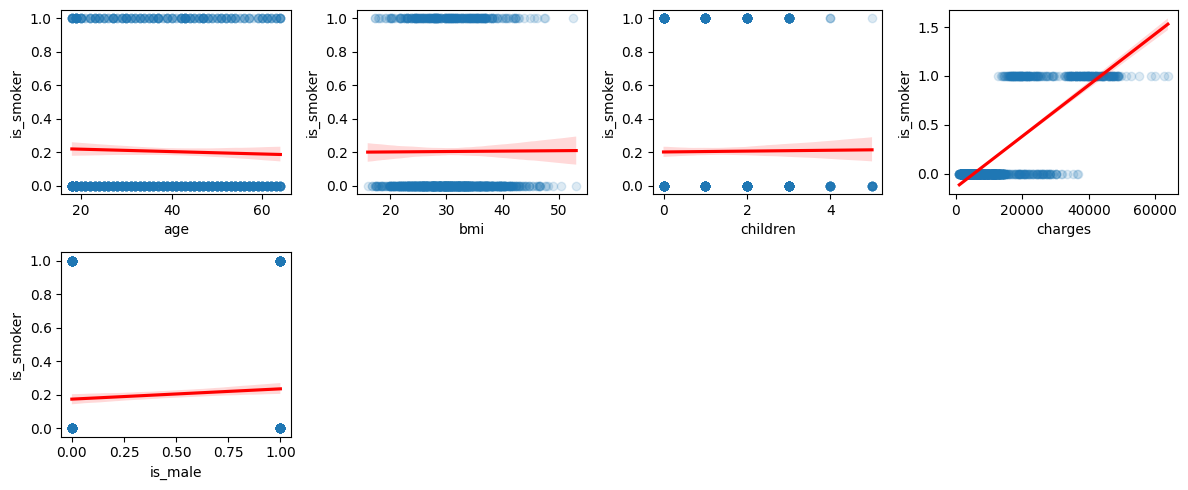

In [11]:
# pairplots


y_var='is_smoker'
rdu.plot_pairplots(data=df, y_var=y_var)

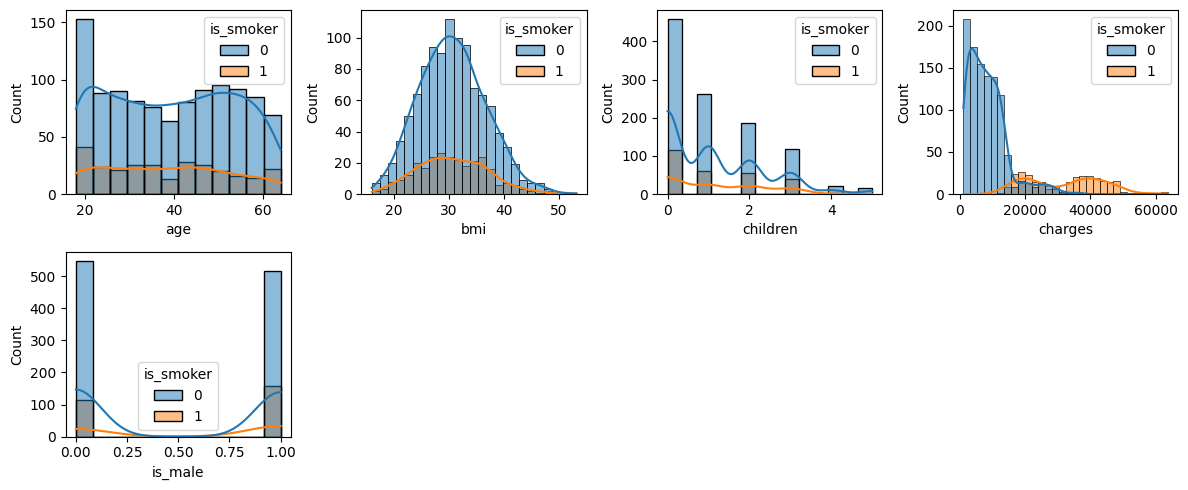

In [12]:
# histograms
rdu.plot_histograms(data=df, y_var=y_var)

# Logistická regrese

Pomocí logistické predikce budeme modelovat hodnotu proměnné `is_smoker`, tedy zda-li se jedná o kuřáka, anebo ne.

## Rozdělení na X a y

In [58]:
# dataframe vysvětlujících proměnných X
X = df[['charges']]
X.head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


In [59]:
# series vysvětlované proměnné y (charges)
y = df['is_smoker']  # <-- STUDENT
y.head()

0    1
1    0
2    0
3    0
4    0
Name: is_smoker, dtype: int8

## Rozdělení na train a test

In [60]:
# rodělení na trénovací a testovací množinu
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
# kontrola velikosti zíkaných datasetů
X_train.shape

(1003, 1)

In [62]:
X_test.shape

(335, 1)

## Nácvik modelu

In [63]:
# vytvoření objektu regrese
logr = LogisticRegression(penalty=None) # <-- STUDENT

In [64]:
# nacvik modelu na trénovací množině
logr.fit(X_train,y_train)

LogisticRegression(penalty=None)

## Predikce

In [65]:
# predikce na testovací množině
y_logr_pred = logr.predict(X_test) # <-- STUDENT
y_logr_pred[:5]

array([0, 0, 1, 0, 1], dtype=int8)

## Vyhodnocení modelu

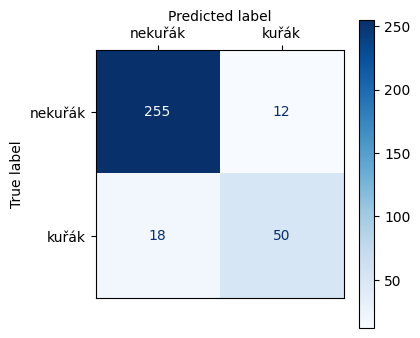

In [66]:
# zobrazíme confusion matrix
cm = confusion_matrix(y_test, y_logr_pred)
rdu.plot_cm(cm, display_labels=['nekuřák', 'kuřák'])

In [67]:
# získáme hodnoty z confusion matrix
tn, fp, fn, tp = cm.ravel()

In [68]:
tp

50

In [69]:
tn

255

In [70]:
fp

12

In [71]:
fn

18

In [72]:
# vypočtěte počet všech správně určených predikcí (kuřáků i nekuřáků)
tn + tp


305

In [73]:
# vypočtěte počet všech špatně určených predikcí (kuřáků i nekuřáků)
fp + fn


30

### Senzitivita

In [74]:
# spočtěte sensitivitu (True positive rate, recall)
sensitivity = tp / (tp + fn)  # <-- STUDENT
sensitivity

0.7352941176470589

In [75]:
print(f'Model správně predikoval {np.round(sensitivity*100, 2)} % ze všech kuřáků.')

Model správně predikoval 73.53 % ze všech kuřáků.


*pozn.: k zobrazení textu výše používáme F-string, viz např. https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/*

### Specificita

In [76]:
# spočtěte specificitu (True negative rate)
specificity =  tn / (tn + fp)  # <-- STUDENT
specificity

0.9550561797752809

In [77]:
print(f'Model správně predikoval {np.round(specificity*100, 2)} % ze všech nekuřáků.')

Model správně predikoval 95.51 % ze všech nekuřáků.


### Accuracy

In [78]:
# spočtěte accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)  # <-- STUDENT
accuracy

0.9104477611940298

In [79]:
print(f'Z {tp + fp + tn + fn} pozorování jich {np.round(accuracy*100, 2)} % bylo predikováno správně.')

Z 335 pozorování jich 91.04 % bylo predikováno správně.


### Precision

In [80]:
# spočtěme precision
precision = tp / (tp + fp)  # <-- STUDENT
precision

0.8064516129032258

In [81]:
print(f'Z {tp + fp} predikovaných kuřáků jich {np.round(precision*100, 2)} % bylo predikováno správně.')

Z 62 predikovaných kuřáků jich 80.65 % bylo predikováno správně.


### ROC křivka

Použijte funkci `RocCurveDisplay` pro zobrazení ROC křivky na testovacích datech.

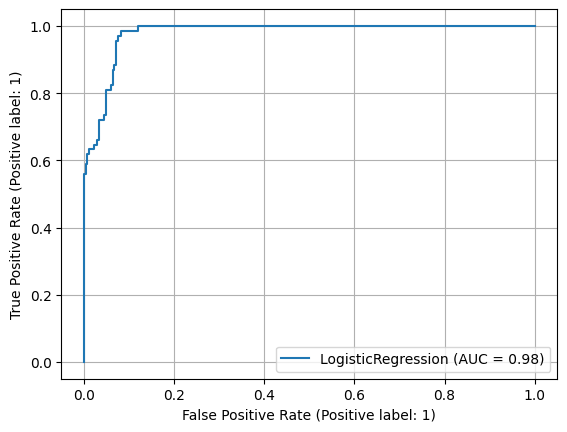

In [84]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve
plt.rcParams['axes.grid'] = True
RocCurveDisplay.from_estimator(logr, X_test, y_test);


**OTÁZKA:** Předpokládejme, že chceme náš model nakalibrovat tak, aby se nestalo, že někoho označíme jako kuřák a daný subjekt přitom kuřák nebyl. Najděte na ROC křivce takový bod (úsek křivky), který tomuto stavu odpovídá (alespoň tedy na testovacích datech). Jaké nejvyšší sensitivity můžeme v takovém případě dosáhnout? Výsledek vyčtěte z grafu a zakorouhlete na jedno desetinné místo.

**ODPOVĚĎ STUDENT:** Divam se na TPR a jedna sa o hodnotu tesne pod 0.6.

# Rozhodovací strom

- V následující části nacvičíte na stejných datech rozhodovací strom.
- Zobrazíte rozhodovací strom
- Porovnáte skóre rozhodovacího stromu a logistické regrese

### Výpočet

In [85]:
max_depth = 3
x_vars = list(X.columns)
labels = ['non-smoker', 'smoker']

In [87]:
# vytvoření objektu rozhodovacího stromu (DecisionTreeClassifier), použijte maximální hloubku stromu 3 a random_state=42
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)

In [88]:
# nácvik modelu na trénovací množině
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

### Vizualizace

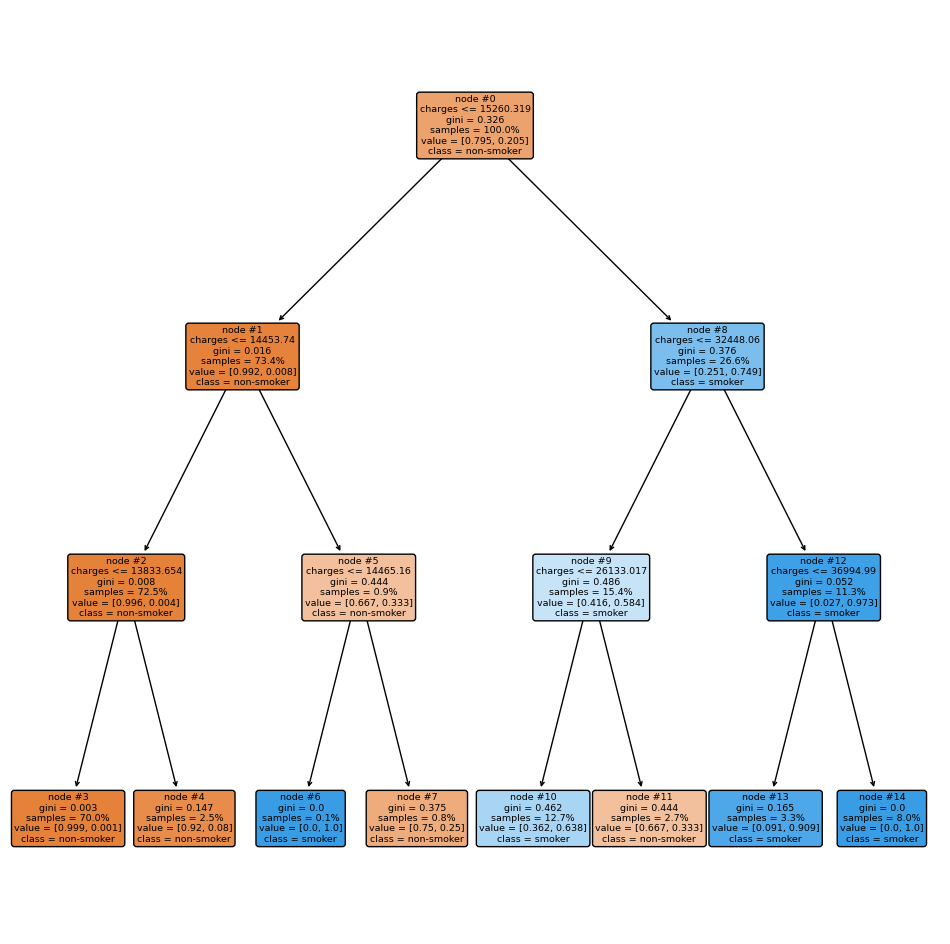

In [89]:
# vizualizace
plt.figure(figsize=(max_depth*4,max_depth*4))
plot_tree(tree_clf, class_names=labels, node_ids=True, filled=True, proportion=True, rounded=True, feature_names=x_vars)
plt.show()

**OTÁZKA:**

Předpokládejme pozorování s následujícími hodnotami:

`charges=10000`
`children=2`
`age=40`
`bmi=20`

Použijte zobrazený strom a odpověztě na tyto dvě otázky:
Lístek (leaf node) se kterým číslem odpovídá těmto hodnotám (např. node #14)? Jaká je predikovaná třída pro tyto hodnoty?

**ODPOVĚĎ STUDENT:** Jedna sa o node#3 a pro tyto hodnoty je predikovana trida non-smoker

### Vyhodnocení

In [90]:
def print_scores(models, labels, X_train, X_test, y_train, y_test):
    """Vypočte skóre všech modelů

    :param models: list modelů
    :param labels: list názvů modelů
    :param X_train:
    :param X_test:
    :param y_train:
    :param y_test:
    """
    scores_train = []
    scores_test = []

    # iterate over each model
    for model in models:
        scores_train.append(np.round(model.score(X_train, y_train), 3))
        scores_test.append(np.round(model.score(X_test, y_test), 3))

    results = pd.DataFrame({
        'Train': scores_train,
        'Test': scores_test
    }, index=labels)

    return results

In [91]:
print_scores([logr, tree_clf], ['Logistic regression', 'Decision tree'], X_train, X_test, y_train, y_test)

,Train,Test
Logistic regression,0.898,0.910
Decision tree,0.937,0.937


**OTÁZKA:** Který z modelů je přesnější na testovací množině?

**ODPOVĚĎ STUDENT:** Z modelu je presnejsi Decision tree prože je bližšie k 1 a nema žadny rozdil mezi train a test množinou dat.